&nbsp;

# IBM Q Backends and Quantum Superdense Coding

&nbsp;

## Contents

&nbsp;

1. [Working with the IBMQ backends](#ibmq)
    
    1.1 [Experimental properties](#exp)
    
    1.2 [Interactive tools](#ipywid)
    
    1.3 [Quantum half-adder, revisited](#qha)
    
    
2. [Superdense coding](#superdense)

&nbsp;

# 1. Working with the IBMQ backends<a id='ibmq'></a>

&nbsp;

#### Loading the IBMQ account


The `IBMQ` module of Qiskit provides the framework to work with the free-access quantum devices that are currently available.

<div class="alert alert-block alert-info">
    
**Managing your [access](https://quantum-computing.ibm.com/docs/manage/account/ibmq) token**

&nbsp;


Before working with the backends for the first time, a `TOKEN` from an [IBM Quantum Experience](https://quantum-computing.ibm.com/) account is necessary. After creating and logging into an account, the token string can be copied from:

&nbsp;

<p style="text-align: center;"><a href="https://quantum-computing.ibm.com/account">https://quantum-computing.ibm.com/account</a></p>

&nbsp;

This string is used as a personal credential for handling communication with the quantum processors. There are several commands to manage credentials:

- `enable_account('TOKEN')`: Enable account in the current session.
- `save_account('TOKEN')`: Save account to disk for future use.
- `load_account()`: Load account using stored credentials.
- `disable_account()`: Disable account in the current session.
- `stored_account()`: List the account stored to disk.
- `active_account()`: List the account currently in the session.
- `delete_account()`: Delete the saved account from disk.

</div>


In [1]:
from qiskit import (QuantumCircuit, ClassicalRegister, QuantumRegister, 
                    IBMQ, Aer, execute, transpile)

from qiskit.tools.visualization import plot_histogram, plot_circuit_layout, plot_gate_map

from qiskit.providers.ibmq import least_busy

from math import pi
import numpy as np

In [2]:
# Replace TOKEN with your string

#IBMQ.save_account('TOKEN')

# In subsequent sessios the Token can be loaded from disk

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [4]:
# Use least_busy() to find out which quantum device is the least busy

physical_devices = provider.backends(simulator=False, operational=True, open_pulse=False)

backend = least_busy(physical_devices)

# Alternative: get backend directly by name

#backend = provider.get_backend('ibmq_XXXXXXX')

print(backend)

ibmq_manila


## 1.1 Quantum devices - experimental properties<a id='exp'></a>

#### [Basis Gates](https://qiskit.org/documentation/apidoc/transpiler.html)

Although IBM's interface allows the user to program a quantum algorithm using a broad set of single and multi-qubit gates, these are compiled into a smaller set of compiler instruction:

In [5]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

#### [Qubit map](https://qiskit.org/documentation/apidoc/transpiler.html)

Besides the restriction regarding the available gates, there are further physical constraints given by the physical architecture of the chip. In fact, CNOT gates can be directly applied only to qubits that are connected.

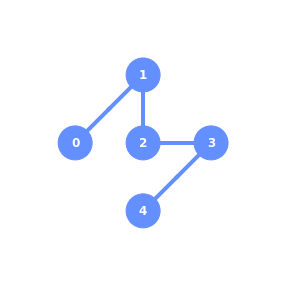

In [6]:
plot_gate_map(backend)

There are ways to circumvent the chip's architecture limitations (for example, by using SWAP operations to allow for a CNOT gate between otherwise physically uncoupled qubits). 

The study and development of efficient mapping algorithms between logical (software) and physical qubits, for a given quantum program, has only recently started receiving serious attention from the quantum information community. **As the size and complexity of quantum processor chips increase, efficient mapping algorithms will become crucial to successful demonstrations of the applications of quantum computers.**

<img src="https://qiskit.org/documentation/_images/mapping.png" width="800px" align="center">


#### Coherence times

Current quantum computations are 'fragile'. A physical qubit does not hold its state indefinitely but undergoes random bit-flips and loses its phase over time, i.e. some interactions introduce *noise*. IBM Q has two timescales arising from relaxation and decoherence ($T_1$ and $T_2$
respectively), which limits the number of quantum operations performed before the results are 'drowned' by noise.

$T_1$ or *amplitude damping time* is the time scale over which the state of a qubit damps to state $|1\rangle$. 
On the other hand, $T_2$, the *phase damping* relates to decoherence. Decoherence is the loss of quantum 'properties' of a quantum system. In other words, a classical mixture can express a state that undergoes decoherence. 

<div class="alert alert-block alert-info">
    
**How are coherence times determined experimentally?**

&nbsp;

One way to estimate $T_1$ is to initialize a qubit to the ground state $| 0 \rangle$ (for example, apply an $X$ gate to turn it into $| 1 \rangle$, and measure it in the computational basis after a time $t$. 

The probability of the qubit staying in the $| 1 \rangle$ state is expected to follow an exponential decay curve $e^{-t/T_1}$. 

To experimentally determine $T_2$, one can initialise a qubit to the ground state $| 0 \rangle$, apply an Hadamard transform $H$ to change it into $\frac{| 0 \rangle + | 1 \rangle}{\sqrt{2}}$ and wait for a time $t$ before applying another transform $H$ and measuring the qubit on the computational basis.

You can try [Relaxation and Decoherence](https://github.com/CQCL/qiskit-tutorial/blob/a2c8410ba62450d5f09d937bfbcda1497d9e5461/qiskit/ignis/relaxation_and_decoherence.ipynb).
    
**Note** T1 and T2 are not "time from state x to state y" but rather decay constants.
                                                                                      
</div>

&nbsp;

Information on a given `backend`, such as qubit configuration or noise properties, can be retrieved by calling on the instance 
properties.

In [7]:
# Check backend status
backend.status()

In [8]:
# Check configuration
config = backend.configuration()

# to_dict() displays configuration in dict form - easier to read
config.to_dict()

{'backend_name': 'ibmq_manila',
 'backend_version': '1.0.37',
 'n_qubits': 5,
 'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset'],
 'gates': [{'name': 'id',
   'parameters': [],
   'qasm_def': 'gate id q { U(0, 0, 0) q; }',
   'coupling_map': [[0], [1], [2], [3], [4]]},
  {'name': 'rz',
   'parameters': ['theta'],
   'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }',
   'coupling_map': [[0], [1], [2], [3], [4]]},
  {'name': 'sx',
   'parameters': [],
   'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }',
   'coupling_map': [[0], [1], [2], [3], [4]]},
  {'name': 'x',
   'parameters': [],
   'qasm_def': 'gate x q { U(pi, 0, pi) q; }',
   'coupling_map': [[0], [1], [2], [3], [4]]},
  {'name': 'cx',
   'parameters': [],
   'qasm_def': 'gate cx q0, q1 { CX q0, q1; }',
   'coupling_map': [[0, 1],
    [1, 0],
    [1, 2],
    [2, 1],
    [2, 3],
    [3, 2],
    [3, 4],
    [4, 3]]},
  {'name': 'reset', 'parameters': None, 'qasm_def': None}],
 'local': False,
 'simulator': False,
 'cond

In [9]:
properties = backend.properties()

properties.to_dict()

{'backend_name': 'ibmq_manila',
 'backend_version': '1.0.37',
 'last_update_date': datetime.datetime(2022, 10, 7, 21, 9, 15, tzinfo=tzlocal()),
 'qubits': [[{'date': datetime.datetime(2022, 10, 7, 19, 20, 20, tzinfo=tzlocal()),
    'name': 'T1',
    'unit': 'us',
    'value': 99.08249715414877},
   {'date': datetime.datetime(2022, 10, 7, 7, 3, 25, tzinfo=tzlocal()),
    'name': 'T2',
    'unit': 'us',
    'value': 50.705299199360475},
   {'date': datetime.datetime(2022, 10, 7, 21, 9, 15, tzinfo=tzlocal()),
    'name': 'frequency',
    'unit': 'GHz',
    'value': 4.96228752891957},
   {'date': datetime.datetime(2022, 10, 7, 21, 9, 15, tzinfo=tzlocal()),
    'name': 'anharmonicity',
    'unit': 'GHz',
    'value': -0.3446254135384113},
   {'date': datetime.datetime(2022, 10, 6, 6, 4, 59, tzinfo=tzlocal()),
    'name': 'readout_error',
    'unit': '',
    'value': 0.024799999999999933},
   {'date': datetime.datetime(2022, 10, 6, 6, 4, 59, tzinfo=tzlocal()),
    'name': 'prob_meas0_prep1',

&nbsp;


## 1.2 Interactive tools <a id='ipywid'></a>

The large amount of information on different backends can better be visualized using the integrated interactive tools.

In [10]:
# NOTE: if interactive tools don't work,
# you may need to install ipywidgets.
# If so, execute the line below:

# !pip install ipywidgets

# Interactive tools
import qiskit.tools.jupyter
%matplotlib inline

In [11]:
%qiskit_version_table

<div class="alert alert-block alert-warning">
 
On which computer should you run your experiments today?
    
</div>

In [12]:
%qiskit_backend_overview

After importing the tools, simply invoking a backend instance displays graphical information on the backend.

In [13]:
backend

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

&nbsp;


## 1.3 Quantum half-adder, revisited <a id='qha'></a>

&nbsp;


Recall the quantum half-adder circuit from the previous class, which adds the states of $q_0$ and $q_1$, and outputs the *sum* S to $q_1$ and the *carry* C to an additional qubit $q_2$:

&nbsp;

| $q_0$ (input) = A | $q_1$ (input) = B | $q_1$ (output) = S  | $q_2$ (output) = C |
|-----------------|-----------------|-------------------|------------------|
|        0        |         0       |      0            |      0     |
|        1        |         0       |      1            |      0     |
|        0        |         1       |      1            |      0     |
|        1        |         1       |      0            |      1     |


&nbsp;


We can now compare the results of the quantum half adder under ideal conditions (when using the simulator) and when executed on a physical quantum processor.

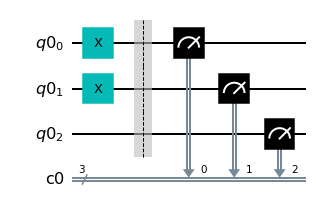

In [3]:
# Create registers
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

# Quantum Circuit
half_adder = QuantumCircuit(qr, cr)

# We are adding q0 = |1> and q1 = |1>
half_adder.x(qr[0])
half_adder.x(qr[1])

# Perform operation for quantum half-adder




# Barriers make circuits prettier
half_adder.barrier()

# Measure
half_adder.measure(qr, cr)

# Draw
half_adder.draw(output='mpl')

Recall that under noiseless settings and deterministic inputs (since inputs are not in superposition), the output is deterministic: $q_0 = 1$, $q_1 = 0$ (sum) and $q_2 = 1$ (carry). 

<div class="alert alert-block alert-warning">
What is the expected outcome?
</div>

In [4]:
sim_backend = Aer.get_backend("qasm_simulator")

shots = 1024

# Execute the circuit:

#job_half_adder_s = 

#result_half_adder_s = 
#counts_half_adder_sim = 



# plot histogram:




#### Visualizing circuit decompositions

Before being executed on a physical backend, the circuit is decomposed. This decomposition can be visualized using the `transpile` function.

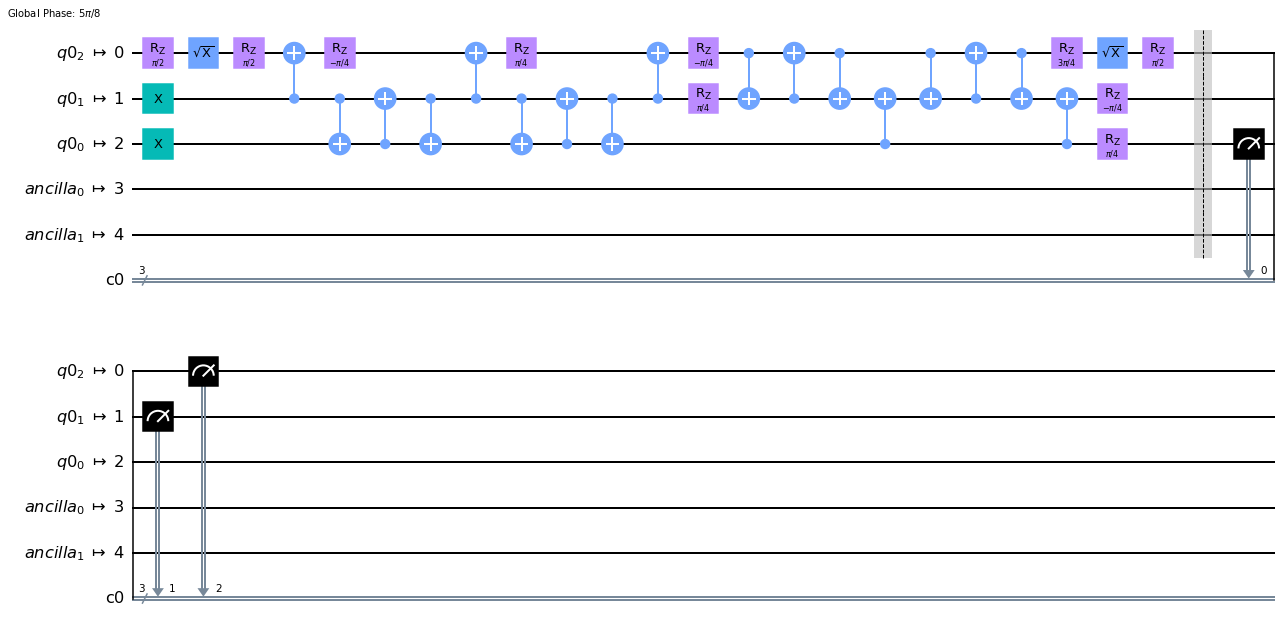

In [16]:
# To visualize the decomposition, we have to specify the backend
# get_backend() to define backend
physical_backend = provider.get_backend('ibmq_belem')

                       
# With transpile we can see exactly what is running on the backend
qc_real = transpile(half_adder, backend=physical_backend)

qc_real.draw(output='mpl')

#### Comparing the number of layers

We can compare the number of *layers* between the original and the compiled circuit. 

A *layer* is comprised of all quantum operations that can be executed concurrently, before the quantum device executes the next cycle of operations.

<img src="https://qiskit.org/documentation/locale/de_DE/_images/depth.gif" width="800 px" />

In [17]:
print('Original circuit')
print('Depth:', half_adder.depth())
print('Gate counts:', half_adder.count_ops())
print()

circlist=[]
for kk in range(4):
    circ = transpile(half_adder, backend, optimization_level=kk)
    circlist.append(circ)
    print('Optimization Level {}'.format(kk))
    print('Depth:', circ.depth())
    print('Gate counts:', circ.count_ops())
    print()

Original circuit
Depth: 4
Gate counts: OrderedDict([('measure', 3), ('x', 2), ('ccx', 1), ('cx', 1), ('barrier', 1)])

Optimization Level 0
Depth: 21
Gate counts: OrderedDict([('cx', 13), ('rz', 11), ('measure', 3), ('x', 2), ('sx', 2), ('barrier', 1)])

Optimization Level 1
Depth: 20
Gate counts: OrderedDict([('cx', 11), ('rz', 10), ('measure', 3), ('x', 2), ('sx', 2), ('barrier', 1)])

Optimization Level 2
Depth: 16
Gate counts: OrderedDict([('rz', 10), ('cx', 8), ('measure', 3), ('sx', 2), ('x', 2), ('barrier', 1)])

Optimization Level 3
Depth: 28
Gate counts: OrderedDict([('rz', 15), ('cx', 8), ('sx', 6), ('x', 4), ('measure', 3), ('barrier', 1)])



We can also visually see which qubits are used for the circuit.

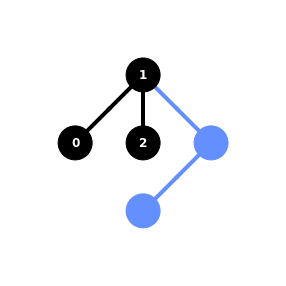

In [18]:
plot_circuit_layout(circlist[0], physical_backend)

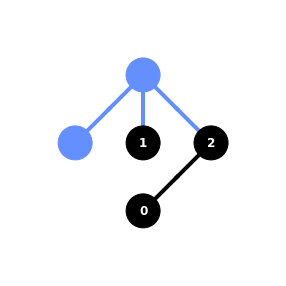

In [19]:
plot_circuit_layout(circlist[3], physical_backend)

#### Comparing results

<div class="alert alert-block alert-danger">

**Run the following cells only at the end of the class.**

</div>

In [20]:
# Execute the DJ algorithm on physical backend

# Enable job monitoring
%qiskit_job_watcher

# To disable: %qiskit_disable_job_watcher
#
#job_ha_real = execute(circlist[1], physical_backend, shots=shots)

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [ ]:
# We can save the job ID to retrieve results even after closing the notebook
#job_ha_real.job_id()

In [27]:
# This can be achieved using the retrieve_job('ID') method
#job_ha_real = physical_backend.retrieve_job('ID')
job_ha_real = physical_backend.retrieve_job('63408d24d41d5e27ccd30d1b')

In [22]:
# We can also check the job status
job_ha_real.status()


<JobStatus.VALIDATING: 'job is being validated'>

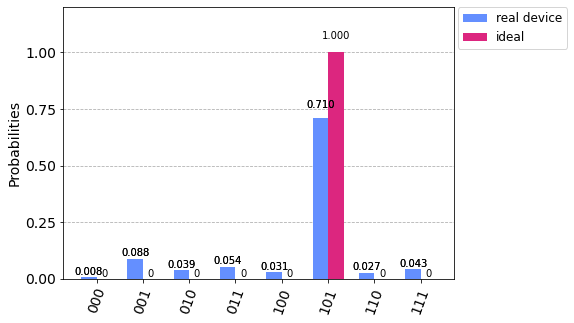

In [23]:
result_ha_real = job_ha_real.result()
counts_ha_real = result_ha_real.get_counts(half_adder)

plot_histogram([counts_ha_real, counts_half_adder_sim], legend=[ 'real device', 'ideal'])

# 2. Superdense Coding <a id='superdense'></a>

In 1970, Charles H. Bennett and Stephen Wiesner proposed the Superdense Coding protocol for the first time. This protocol is thought of as the opposite of quantum teleportation, which transmits one qubit using two classical bits. Superdense coding transmits two classical bits using one qubit. 

![process](https://qiskit.org/textbook/ch-algorithms/images/superdense.jpg)

1. As illustrated above, the protocol starts with a third party (Charlie) preparing the entanglement between two quantum states. 

2. The two qubits are then sent to the sender (Alice) and the receiver (Bob):
$$|\psi\rangle_{AB} = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B)$$
The first qubit, denoted by subscript $A$, belongs to Alice, and the second qubit, $B$, belongs to Bob.

3. The following step is encoding. Alice needs to apply a set of quantum gates to her qubit depending on the 2 bits of classical information she wants to send. 

|Intended Message| Applied Gate| Resulting State ($\times \frac{1}{\sqrt{2}}$)|
|--|--|--|
|00|I| $|00\rangle+ |11\rangle$
|01|X| $|10\rangle+ |01\rangle$
|10|Z| $|00\rangle- |11\rangle$
|11|ZX|$-|10\rangle+ |01\rangle$

4. When Bob receives Alice's qubit, he only has to apply the restoration operation. 

|Bob Receives ($\times \frac{1}{\sqrt{2}}$)| After the CNOT-gate ($\times \frac{1}{\sqrt{2}}$)| After H-gate|
|--|--|--|
|$|00\rangle+ |11\rangle$| $|00\rangle+ |10\rangle$ | $|00\rangle$|
|$|10\rangle+ |01\rangle$| $|11\rangle+ |01\rangle$ | $|01\rangle$|
|$|00\rangle- |11\rangle$| $|00\rangle- |10\rangle$ | $|10\rangle$|
|$-|10\rangle+ |01\rangle$|$-|11\rangle+ |01\rangle$| $|11\rangle$|


<div class="alert alert-block alert-warning">

**Implementing the superdense coding protocol**

&nbsp;

Implement the superdense coding admitting that Alice wants to send the bits $11$

&nbsp;


The protocol can be broken down into several steps:

- Entangle qubits `qa` and `qb` so that $|qa \; qb \rangle = |00\rangle + |11\rangle$. This can be achieved with a Hadamard and a CNOT gate;

- Encode the message in Alice's qubit.

- Decode the message.

- And measure.
    
Finally, simulate your program.
    
</div>

Refs: 
* [Qiskit superdense coding](https://qiskit.org/textbook/ch-algorithms/superdense-coding.html)
* [Wiki superdense coding](https://en.wikipedia.org/wiki/Superdense_coding)

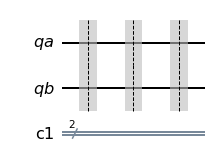

In [24]:
# Qubits A, B and C as separate registers
qa = QuantumRegister(1, 'qa')
qb = QuantumRegister(1, 'qb')

# Alice needs two bits; Bob needs one
c_bob = ClassicalRegister(2)

# Initialize circuit
sdc_circuit = QuantumCircuit(qa, qb, c_bob)

# Entangle qa and qb


sdc_circuit.barrier()
# Encode

sdc_circuit.barrier()
# Decode

sdc_circuit.barrier()
# Measure 

# Draw circuit
sdc_circuit.draw(output='mpl')

In [25]:
# Simulate

# Plot histogram